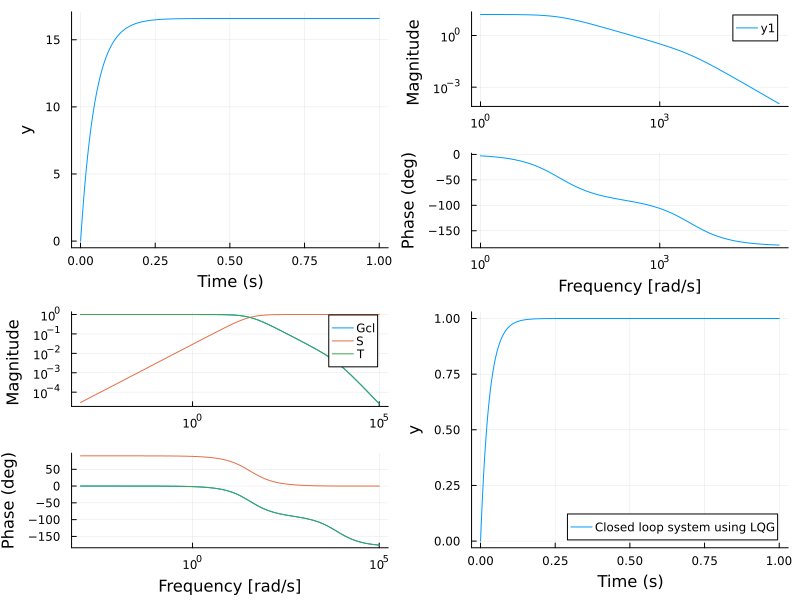

In [12]:
using ControlSystems, Plots
"""
Example for designing an LQG speed controller for an electrical DC motor.
"""

# Constants
Ke                      = 0.006156           # electromotive force constant in V/rpm
Kt                      = 0.0728             # Torque constant (Nm/A)
J                       = 2.8*700e-6;        # Inertia of motor plus load (kgm^2)
Rel                     = 0.11;              # DC motor resistance (Ω)
L                       = 34e-6;             # DC motor inductance (H)

# helper to convert a scalar into an 1x1 Matrix
mat(sc) = reshape([sc],1,1)

# Create an instance of a DC motor model in state space form.
# Ke: electromotive force constant in V/rpm
# Kt: torque constant (Nm/A)
# L: Inductance; R: Resistance, J: Inertia; b: viscous friction coefficient
function motor(Ke, Kt, L, R, J, b=1e-3)
    Ke1 = Ke*60.0/2π   # change unit to rad/s
    A = [-b/J     Kt/J
         -Ke1/L   -R/L];
    B = [0
        1/L];
    C = [1     0];
    D = 0;
    sys = ss(A, B, C, D);
end

p60 = motor(Ke, Kt, L, Rel, J)
f1 = plot(step(p60, 1))
f2 = bodeplot(p60)

# LQR control
Q = [1.     0;
     0      1]

R = 20.
K = lqr(p60, Q, R)
# needs to be modified if Nbar is not a scalar
Nbar = 1. ./ (p60.D - (p60.C - p60.D*K) * inv(p60.A - p60.B*K) * p60.B)

# Kalman filter based observer
Vd = [10.     0   # covariance of the speed estimation
     0       10]; # covariance of the current estimation
Vn = 0.04;       # covariance for the speed measurement (radians/s)^2
Ka = kalman(p60, Vd, mat(Vn))
C = ControlSystems.observer_controller(p60, K, Ka)

Gcl = let (A,B,C,D) = ssdata(p60)
     Acl = [A-B*K B*K; zero(A) A-Ka*C]
     Bcl = [B * Nbar; zero(B)]
     Ccl = [C zero(C)]
     ss(Acl, Bcl, Ccl, 0)
end

T = Gcl
S = 1-T

# 1000 logarithmically spaced values from -3 to 3
f3 = bodeplot([Gcl, S, T], exp10.(range(-3, stop=5, length=10000)), label=["Gcl" "" "S" "" "T" ""])
f4 = plot(step(Gcl, 1), label="Closed loop system using LQG")
plot(f1, f2, f3, f4, layout=(2,2), size=(800, 600))